# Outlier Detection

En este notebook se aplican técnicas de detección de anomalías sobre un conjunto de datos con el fin de aislar los registros asociados a pacientes con tumor y los que no están asociados.

### Tabla de contenidos

- [Carga del dataset](#Carga-del-dataset)
- [Análisis descriptivo de los datos](#Análisis-descriptivo-de-los-datos)
- [Tratamiento de datos - Missing values](#Tratamiento-de-datos---Missing-values)
- [Detección de anomalías](#Detección-de-anomalías)
  - [Táctica 1](#Táctica-1)
  - [Táctica 2](#Táctica-2)
- [Conclusiones](#Conclusiones)

In [1]:
### Imports y funciones auxiliares
import pandas as pd
import numpy as np
import seaborn as sns

import errno
import os
import sys

# Función para validar que el fichero existe
def assert_fichero(nombre):
    if not os.path.isfile(nombre):
        raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), nombre)
        
# Función para imprimir mensajes por la salida de error
def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)

# Función para seleccionar el nombre de las features cuya
# desviación típica esté por debajo del corte indicado
def seleccionar_variables_representativas(df, corte=1.0):
    desviaciones_tipicas = df.std()
    variables_representativas = desviaciones_tipicas > corte
    variables_representativas = list(variables_representativas[variables_representativas == True].index)
    
    return variables_representativas

# Función para descargar un fichero a partir de una url
def descargar_fichero(url):
    
    # Si no está disponible se descarga
    print("Descargando archivo...\r", end='')
    !curl --silent -O {url}
    codigo_retorno = !echo -n "$?"
    codigo_retorno = int(codigo_retorno[0])
    
    if codigo_retorno == 0:
        print("El fichero se ha descargado correctamente!")
    else:
        print("Se ha producido un fallo al descargar el archivo. Código de error: {:d}".format(codigo_retorno))

### Carga del dataset

El conjunto de datos proporcionado se encuentra disponible en [UCI Machine Learning Repository: Breast Cancer Wisconsin (Diagnostic)][link] y concretamente se trabajará con el set `wdbc.data` que puede descargarse de la siguiente manera:


```sh
curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data
```

Este conjunto de datos tiene asociado además el documento `wdbc.names` que contiene información relativa a las variables y contenido del set de datos.

```sh
curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names
```

[link]: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

In [2]:
# Comprobación de que el fichero de datos está disponible
fichero_datos = 'wdbc.data'
if (not os.path.isfile(fichero_datos)):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
    descargar_fichero(url)
        
assert_fichero(fichero_datos)

# Carga del archivo como un DataFrame de Pantas con separador de columnas ','
features = ['feat{:02d}'.format(x) for x in range(1, 31)]
columnas = ['id', 'diagnosis'] + features
df_raw = pd.read_csv(fichero_datos, sep=',', names=columnas, index_col='id')

# Muestra las primeras 5 columnas de los primeros registros
df_raw.iloc[:, 0:5].head()

,diagnosis,feat01,feat02,feat03,feat04
id,,,,,
842302,M,17.99,10.38,122.80,1001.0
842517,M,20.57,17.77,132.90,1326.0
84300903,M,19.69,21.25,130.00,1203.0
84348301,M,11.42,20.38,77.58,386.1
84358402,M,20.29,14.34,135.10,1297.0


### Análisis descriptivo de los datos

Como se indica en el documento `wdbc.names`, el conjunto de datos dispone de dos primeras columnas con el número de ID del registro y una clase categórica que indica el diagnóstico referente al tipo de tumor, `M` para tumor *maligno*, y `B` para tumores *benignos*.

El resto de columnas, `30` concretamente, son variables numéricas que hacen referencia a distintas mediciones sobre los tumores.

En el mismo documento ya se indica que hay un total de `569` registros, donde `357` son *benignos* y `212` son *malignos*.

Esta relación: $M / B \sim 0.59$ revela que la relación entre ambas categorías no es nada despreciable, lo que a priori hace pensar que la detección de anomalías será poco potente dado que el número de registros de anomalías (tumores *malignos* `M`) será del mismo orden al de eventos válidos (tumores *benignos* `B`).

Además, también se menciona en el documento de información que *no hay ningún dato incompleto en el set*. Sin embargo, como medida de precaución se comprobará que todos los datos del *DataFrame* estén completos.

Aunque para el entrenamiento del modelo se trabajará con todas las features, a continuación se representa la correlación entre aquellas features cuya desviación típica es superior `1`.

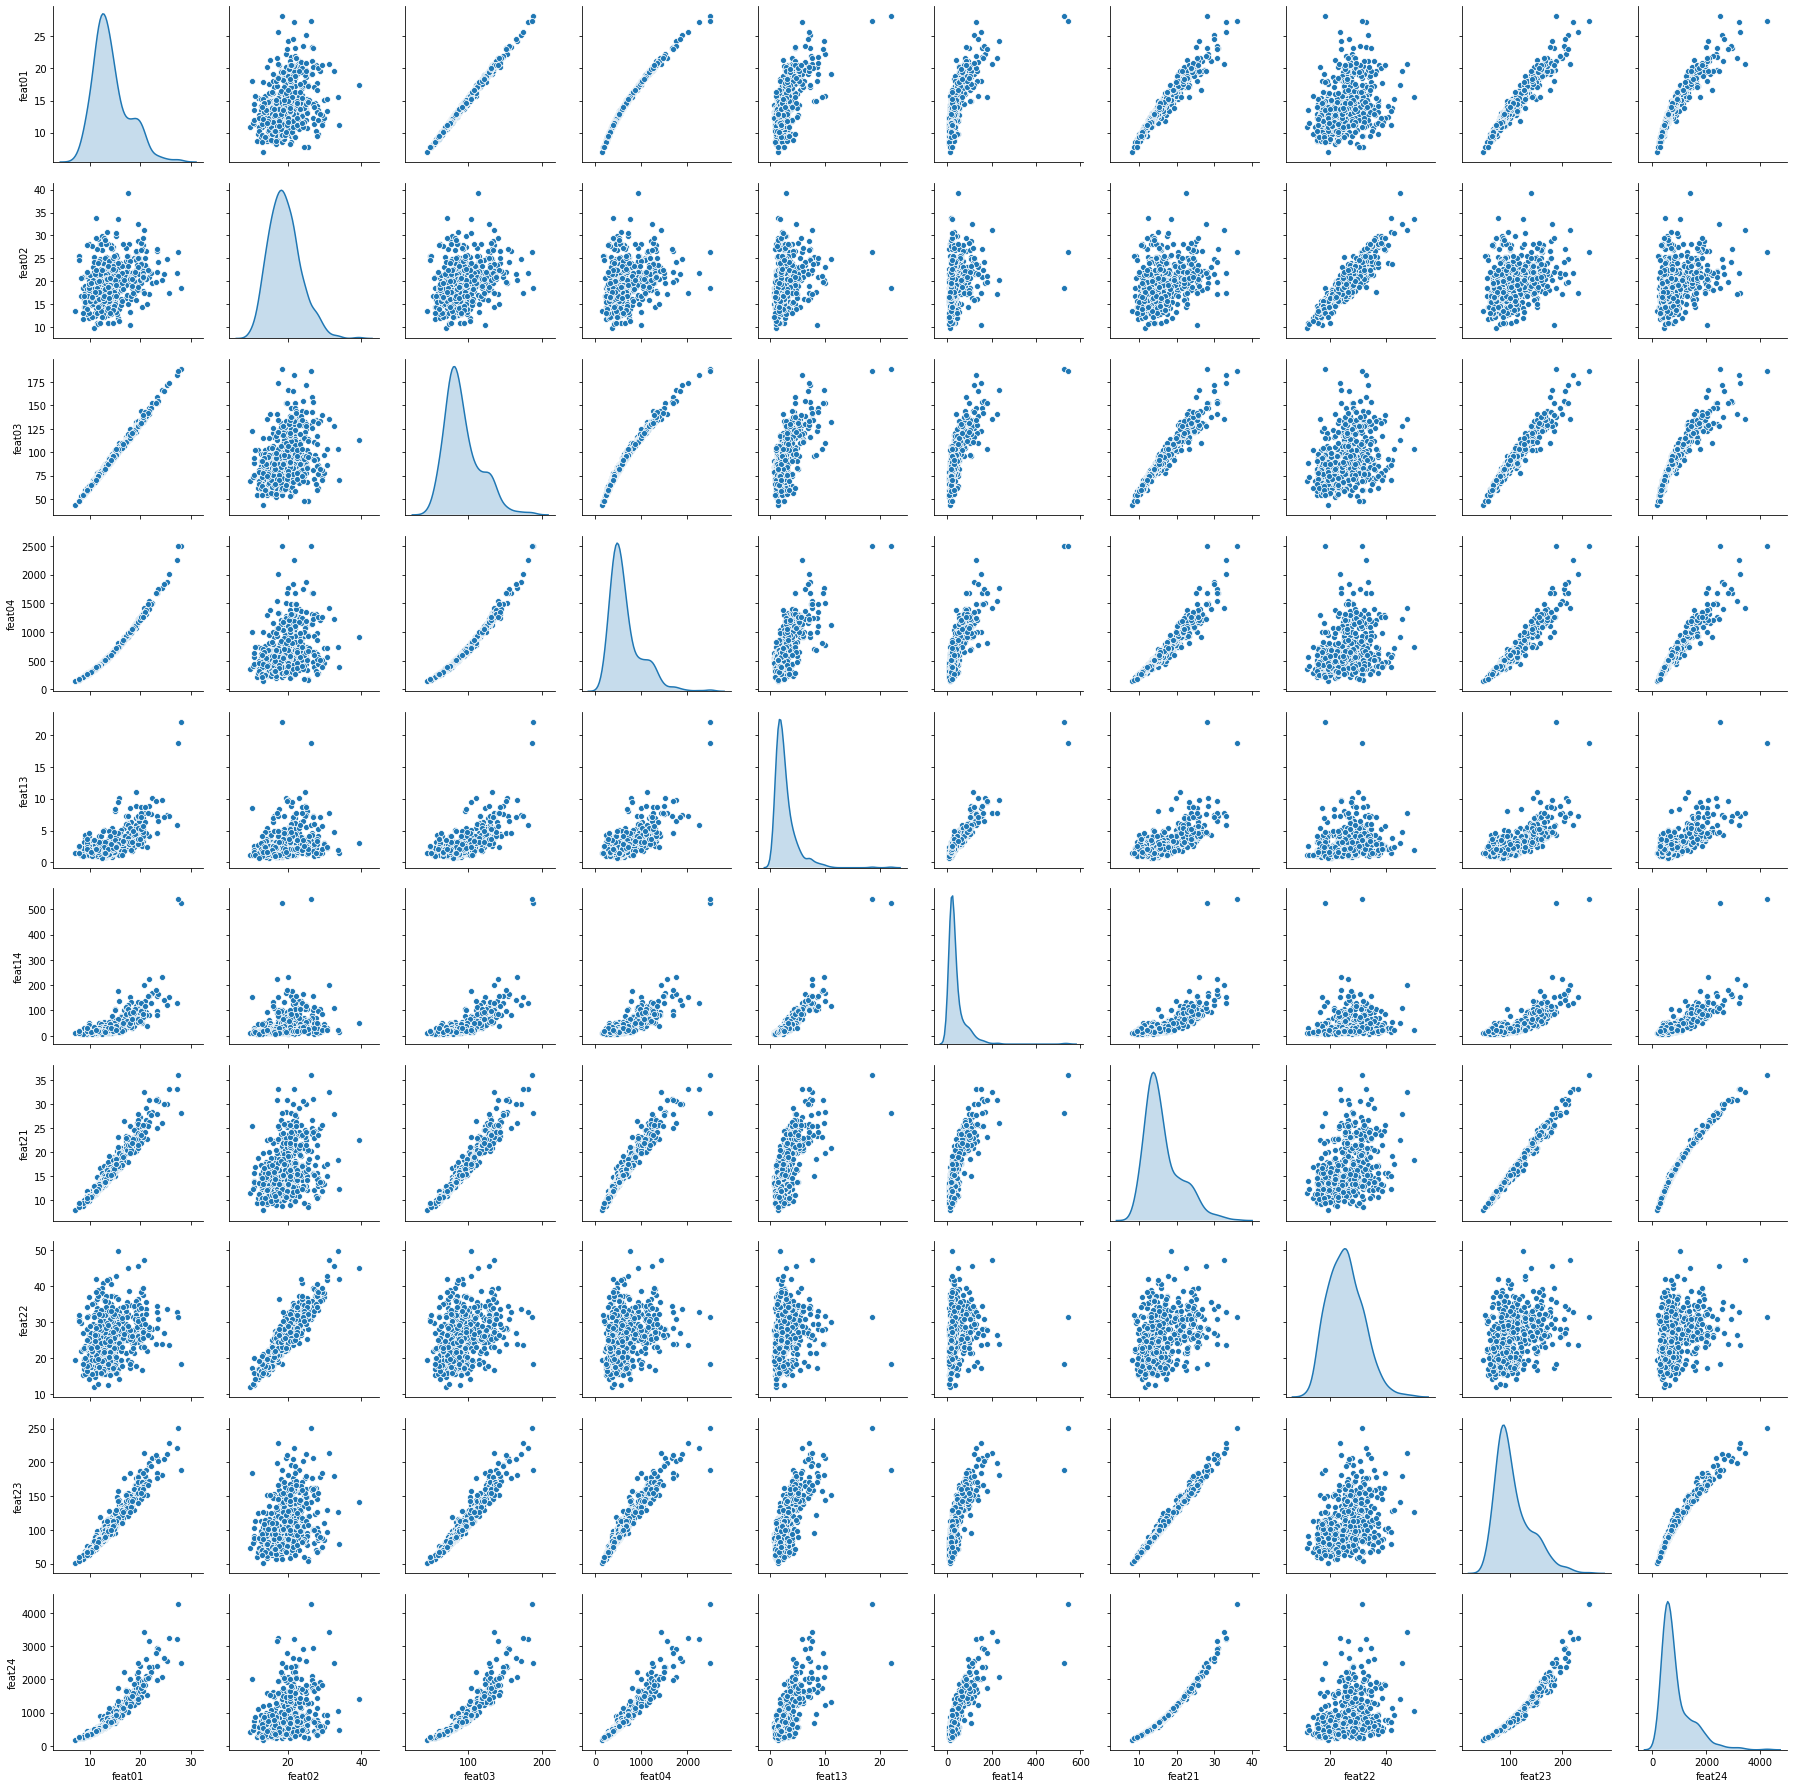

In [3]:
# Representación de la correlación entre las features con mayor std
features_mayor_std = seleccionar_variables_representativas(df_raw[features], corte=float(1.0))
_ = sns.pairplot(df_raw[features_mayor_std], diag_kind="kde")

Revisando las gráficas pueden apreciarse puntos que claramente están separados del resto, lo que los hace susceptibles de ser detectados por el algoritmo de detección de anomalías.

Sin embargo también se aprencian puntos que podrían ser anomalías pero están demasiado '*pegados*' a los puntos normales como para que el modelo los detecte como anomalías...

### Tratamiento de datos - Missing values

Antes de insertar los datos en el algoritmo de detección de anomalías se va a comprobar que todos los datos están completos.

In [4]:
# Se buscan los registros que tengan algún elemento nulo
numero_registros_con_elementos_nulos = df_raw[df_raw.isnull().any(axis=1)].shape[0]

if numero_registros_con_elementos_nulos > 0:
    eprint("Se han encotrado registros que tienen algún elemento nulo. Hay que tratar el dataset antes de continuar")
else:
    print("No se han encontrado registros que tengan elementos nulos. No hay que hacer limpieza del dataset.")

No se han encontrado registros que tengan elementos nulos. No hay que hacer limpieza del dataset.


### Detección de anomalías

Para llevar acabo la detección de anomalías se va a usar la clase [`sklearn.ensemble.IsolationForest`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) del paquete `sklearn` de Python.

El método `predict` de la clase `IsolationForest` devuelve `1` si el registro se considera una muestra normal, ó `-1` si la muestra se trata de una anomalía.

#### Táctica 1

En este caso se optará por proporcionar todos los datos al modelo sin hacer ningún tratamiento previo de los datos para ver cuál sería el resultado obtenido partiendo del supuesto en que no se conoce ninguna información previa acerca del tipo de tumor registrado.

In [5]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, f1_score

# Construcción y entrenamiento del modelo
modelo_tac1 = IsolationForest(behaviour='new', random_state=10,
                              contamination='auto', max_samples='auto', n_jobs=-1)

df_tac1 = df_raw[features] # Se excluye la feature 'diagnosis'
modelo_tac1.fit(df_tac1)

# Predicciones del modelo
##  1 => datos normales
## -1 => datos anómalos
pred_tac1 = pd.Series(modelo_tac1.predict(df_tac1),
                      name='anomalia', index=df_raw.index)

print("{:d} anomalías detectadas en el conjunto de "
      "entrenamiento de {:d} anomalías reales".format(
          pred_tac1[ pred_tac1 == -1 ].shape[0],
          df_raw[ df_raw['diagnosis'] == 'M' ].shape[0]))

# Cálculo de métricas
# En este dataframe 1 significa valor normal y 0 anomalía
# 'real' corresponde a los datos reales, mientras que
# 'pred' corresponde a las predicciones del modelo
df_metricas = pd.concat([df_raw['diagnosis'], pred_tac1], axis=1, sort=False)
df_metricas.rename(inplace=True, columns={"diagnosis": "real", "anomalia": "pred"})

df_metricas['real'] = df_metricas['real'] == 'B'
df_metricas['pred'] = df_metricas['pred'] == 1

# (La intención de este dataframe es que se preserve la relación mediante el índice que es el id)

# AUC
# Dado que el problema puede verse desde el punto de vista de una clasificación binaria
# de procede a calcular como métrica del error el área bajo la curva ROC
auc_tac1 = roc_auc_score(df_metricas['real'], df_metricas['pred'])
print("Valor de la métrica AUC: {:.2f}%".format(auc_tac1 * 100))

# F-Meassure
# También se calcula como métrica la F-Meassure
f1_tac1 = f1_score(df_metricas['real'], df_metricas['pred'])
print("Valor de la métrica F-Meassure: {:.2f}%".format(f1_tac1 * 100))

56 anomalías detectadas en el conjunto de entrenamiento de 212 anomalías reales
Valor de la métrica AUC: 56.07%
Valor de la métrica F-Meassure: 77.70%


#### Táctica 2

Esta segunda técnica tampoco usará la feature `diagnosis` como predictor del modelo, pero sí se hará uso de la misma para separar el conjunto de datos en dos bloques y hacer un entrenamiento más específico.

El primero de los conjuntos `df_train` sólo contendrá muestras '*normales*' (`diagnosis == 'B'`), mientras que el otro conjunto, `df_valid`, tendrá mezcla de ambos tipos de registros.

La idea de esta táctica es tener un modelo entrenado para casos normales y ver cómo se comporta a la hora de detectar datos que no se parecen tanto a los de entrenamiento (pero comprobando ambos tipos de tumores para no caer en el error del *sobreajuste*).

In [6]:
from sklearn.model_selection import train_test_split

# Separación de registros normales (inliers) y registros anómalos (outliers)
inliers = df_raw[ df_raw['diagnosis'] == 'B' ]
outliers = df_raw[ df_raw['diagnosis'] == 'M' ]

# Separación de los registros normales en un set de entrenamiento y otro temporal
# df_train => 70% de los registros inliers
# df_valid => 30% de los registros inliers y 100% de los outliers
df_train, df_test = train_test_split(inliers, test_size=0.3, random_state=42)
df_test = pd.concat([df_test, outliers])

# Construcción y entrenamiento del modelo
modelo_tac2 = IsolationForest(behaviour='new', random_state=10,
                              contamination='auto', max_samples='auto', n_jobs=-1)

df_tac2 = df_train[features] # Se excluye la feature 'diagnosis'
modelo_tac2.fit(df_tac2)

# Predicciones del modelo
# Por construcción el modelo no tiene ninguna anomalía,
# Sin embargo, para evitar el sobreajuste 
# el modelo tiene un pequeño porcentaje de registros marcados como anomalías

# Comprobación con el set de validación
pred_tac2 = pd.Series(modelo_tac2.predict(df_test[features]),
                      name='anomalia', index=df_test.index)

print("{:d} anomalías detectadas en el conjunto de "
      "entrenamiento de {:d} anomalías reales".format(
          pred_tac2[ pred_tac2 == -1 ].shape[0],
          df_test[ df_test['diagnosis'] == 'M' ].shape[0]))

# Cálculo de métricas
df_metricas = pd.concat([df_test['diagnosis'], pred_tac2], axis=1, sort=False)
df_metricas.rename(inplace=True, columns={"diagnosis": "real", "anomalia": "pred"})

df_metricas['real'] = df_metricas['real'] == 'B'
df_metricas['pred'] = df_metricas['pred'] == 1

# AUC
# Dado que el problema puede verse desde el punto de vista de una clasificación binaria
# de procede a calcular como métrica del error el área bajo la curva ROC
auc_tac2 = roc_auc_score(df_metricas['real'], df_metricas['pred'])
print("Valor de la métrica AUC: {:.2f}%".format(auc_tac2 * 100))

# F-Meassure
# También se calcula como métrica la F-Meassure
f1_tac2 = f1_score(df_metricas['real'], df_metricas['pred'])
print("Valor de la métrica F-Meassure: {:.2f}%".format(f1_tac2 * 100))

199 anomalías detectadas en el conjunto de entrenamiento de 212 anomalías reales
Valor de la métrica AUC: 90.64%
Valor de la métrica F-Meassure: 86.46%


### Conclusiones

Como puede verse de comparar la [táctica 1](#Táctica-1) y la [táctica 2](#Táctica-2), aunque no se proveea al modelo con información clara que le ayude a determinar las anomalías fácilmente, entrenar un modelo con un conjunto de datos saneados donde sólo hay casos normales, mejora notablemente la detección de anomalías.

|*Táctica*|*AUC*|*F-Meassure*|
|:-------:|:---:|:----------:|
|1|`56.07%`|`77.70%`|
|**2**|**`90.64%`**|**`86.46%`**|

En el caso de no poder distinguir de partida las anomalías la situación ideal sería que éstas fuesen pocas y además estuviesen bien separadas de los datos normales para ayudar a la detección de las mismas en la fase de entrenamiento.